# Описание данных.

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Информация о договорах актуальна на 1 февраля 2020 года.<br><br>Информация хранится в четырех датасетах:<br>- contract_new.csv — информация о договоре;<br>- personal_new.csv — персональные данные клиента;<br>- internet_new.csv — информация об интернет-услугах;<br>- phone_new.csv — информация об услугах телефонии.<br><br>Наша задача — обучить на этих данных модель для прогноза оттока клиентов.

## Загрузка данных.

In [1]:
!pip install -q phik

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, make_scorer
import time
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

TEST_SIZE=0.25
RANDOM_STATE=80724

Рассмотрим датасеты.

In [3]:
df_contract_new = pd.read_csv('/datasets/contract_new.csv')
df_personal_new = pd.read_csv('/datasets/personal_new.csv')
df_internet_new = pd.read_csv('/datasets/internet_new.csv')
df_phone_new = pd.read_csv('/datasets/phone_new.csv')

In [4]:
df_contract_new.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [5]:
df_contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
df_personal_new.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [7]:
df_personal_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [8]:
df_internet_new.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [9]:
df_internet_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
df_phone_new.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [11]:
df_phone_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Промежуточный вывод:**<br>Данные были загружены. Теперь приступим к исследовательскому анализу и предобработке данных.

## Исследовательский анализ и предобработка данных.

Выполним проверку на пропуски и дубликаты.

In [12]:
df_contract_new.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [13]:
df_personal_new.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [14]:
df_internet_new.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [15]:
df_phone_new.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

In [16]:
df_contract_new.duplicated().sum()

0

In [17]:
df_personal_new.duplicated().sum()

0

In [18]:
df_internet_new.duplicated().sum()

0

In [19]:
df_phone_new.duplicated().sum()

0

Заменим типы данных столбцов, где это необходимо.

Также в некоторых столбцах со значениями Yes/No необходимо заменить значения на 1/0 для удобства. Таких столбцов будет много, поэтому напишем для этого функцию.

In [20]:
def change(df, column):
    df[column] = df[column].replace('Yes', 1)
    df[column] = df[column].replace('No', 0)

In [21]:
df_contract_new['BeginDate'] = pd.to_datetime(df_contract_new['BeginDate'], format='%Y-%m-%d')

In [22]:
df_contract_new['EndDate'] = df_contract_new['EndDate'].replace('No', '2020-01-02') 

df_contract_new['EndDate'] = pd.to_datetime(df_contract_new['EndDate'], format='%Y-%m-%d')
df_contract_new['TotalCharges'] = pd.to_numeric(df_contract_new['TotalCharges'], errors='coerce')

In [23]:
change(df_contract_new, 'PaperlessBilling')

In [24]:
df_contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 440.3+ KB


In [25]:
change(df_personal_new, 'Partner')
change(df_personal_new, 'Dependents')
df_personal_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   int64 
 4   Dependents     7043 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 275.2+ KB


In [26]:
change(df_internet_new, 'OnlineSecurity')
change(df_internet_new, 'OnlineBackup')
change(df_internet_new, 'DeviceProtection')
change(df_internet_new, 'TechSupport')
change(df_internet_new, 'StreamingTV')
change(df_internet_new, 'StreamingMovies')
df_internet_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   int64 
 3   OnlineBackup      5517 non-null   int64 
 4   DeviceProtection  5517 non-null   int64 
 5   TechSupport       5517 non-null   int64 
 6   StreamingTV       5517 non-null   int64 
 7   StreamingMovies   5517 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 344.9+ KB


In [27]:
change(df_phone_new, 'MultipleLines')
df_phone_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 99.5+ KB


**Промежуточный вывод:**<br>Ни в одном датасете не было обнаружено пропусков и дубликатов. В необходимых местах типы данных и значения столбцов были заменены. Переходим к следующему пункту.

## Объединение данных.

In [28]:
df = df_contract_new.merge(df_personal_new, on='customerID')
df = df.merge(df_internet_new, how='left', on='customerID')
df = df.merge(df_phone_new, how='left', on='customerID')

In [29]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-01-02,Month-to-month,1,Electronic check,29.85,31.04,Female,0,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,NaN
1,5575-GNVDE,2017-04-01,2020-01-02,One year,0,Mailed check,56.95,2071.84,Male,0,0,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3668-QPYBK,2019-10-01,2020-01-02,Month-to-month,1,Mailed check,53.85,226.17,Male,0,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,2016-05-01,2020-01-02,One year,0,Bank transfer (automatic),42.30,1960.60,Male,0,0,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,NaN
4,9237-HQITU,2019-09-01,2020-01-02,Month-to-month,1,Electronic check,70.70,353.50,Female,0,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   int64         
 11  Dependents        7043 non-null   int64         
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   float64       
 14  OnlineBackup      5517 n

In [31]:
df = df.drop('customerID', axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   int64         
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   int64         
 10  Dependents        7043 non-null   int64         
 11  InternetService   5517 non-null   object        
 12  OnlineSecurity    5517 non-null   float64       
 13  OnlineBackup      5517 non-null   float64       
 14  DeviceProtection  5517 n

**Промежуточный вывод:**<br>Объединение прошло успешно. Мы сразу избавились от столбца "customerID", так как дальше он нам не понадобится.

## Исследовательский анализ и предобработка данных объединённого датафрейма.

Прежде чем присупить к анализу полученного датасета, создадим новые признаки:<br>- Длительность контракта (в днях) "ContractLength";<br>- Отток клиентов ("ContractOff").

In [32]:
df['ContractLength'] = (df['EndDate'] - df['BeginDate']).dt.days

In [33]:
def con_off(end_date):
    if end_date == pd.Timestamp('2020-01-02'):
        return 0
    else:
        return 1

df['ContractOff'] = df['EndDate'].apply(con_off)

Теперь можем смело удалить 'EndDate' и 'BeginDate'.

In [34]:
df = df.drop(['BeginDate', 'EndDate'], axis=1)

Для начала разберемся с пропущенными значениями и дубликатами.

In [35]:
df.isna().sum()

Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
ContractLength         0
ContractOff            0
dtype: int64

Смею предпололжить, что пропуски означают отрицательный ответ.

In [36]:
df['InternetService'] = df['InternetService'].fillna('No')
df = df.fillna(0)

In [37]:
df.isna().sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
ContractLength      0
ContractOff         0
dtype: int64

In [38]:
df.duplicated().sum()

4

In [39]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.duplicated().sum()

0

Напишем функции для построения графиков.<br>Для количественнных признаков будет использовать гистограммы, для категориальных/бинарных - столбчатые диаграммы.<br>Также вместе с гистограммами будем строить ящики с усами, чтобы оценить выбросы.

In [40]:
def boxplot_hist(df, column):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.boxplot(data=df, x=column, ax=axes[0])
    axes[0].set_title(f'Ящик с усами "{column}"')
    axes[0].set_ylabel('Количество')

    sns.histplot(data=df, x=column, kde=True, ax=axes[1])
    axes[1].set_title(f'Гистограмма "{column}"')
    axes[1].set_ylabel('Частота')

    plt.tight_layout()
    plt.show()

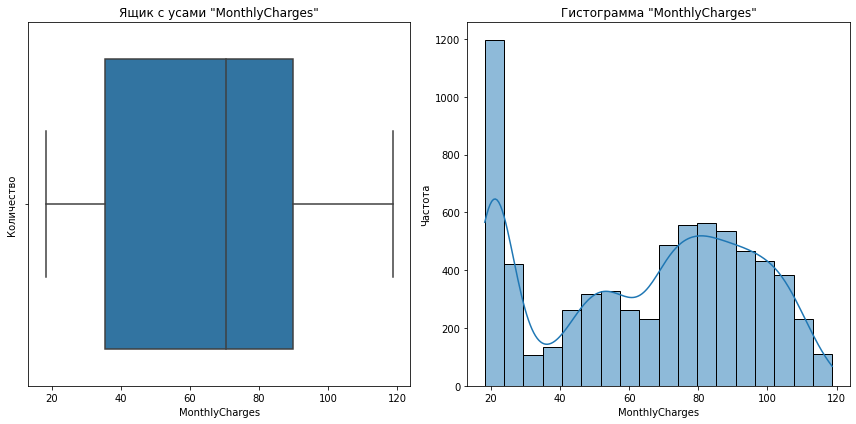

In [41]:
boxplot_hist(df, 'MonthlyCharges')

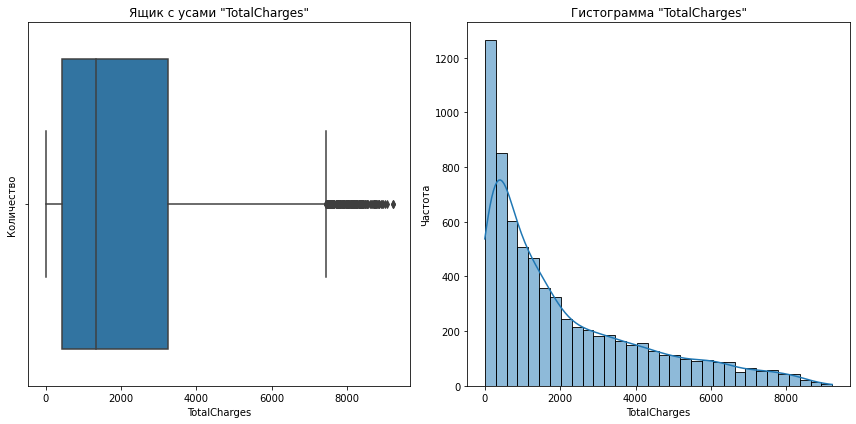

In [42]:
boxplot_hist(df, 'TotalCharges')

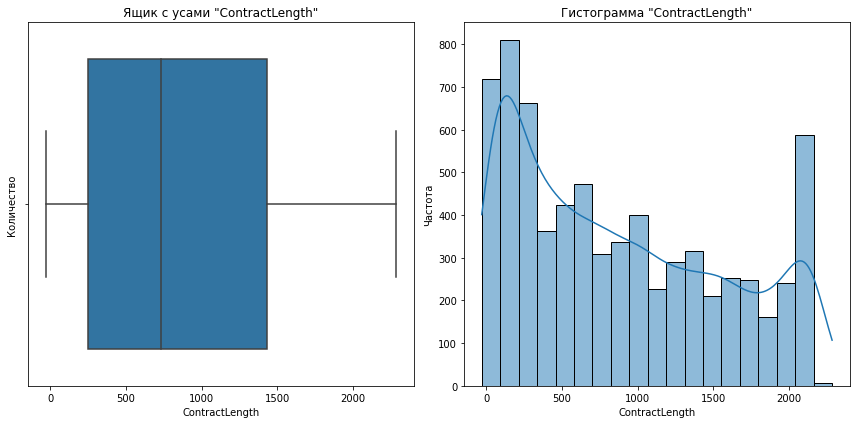

In [43]:
boxplot_hist(df, 'ContractLength')

In [44]:
def barplot_(df, column):
    value_counts = df[column].value_counts()
    percentages = df[column].value_counts(normalize=True) * 100

    result = pd.DataFrame({column: value_counts.index, 'Count': value_counts.values, 'Percentage': percentages.values})

    plt.figure(figsize=(10, 6))
    bar_plot = sns.barplot(data=result, x=column, y='Count')

    for index, row in result.iterrows():
        bar_plot.text(row.name, row.Count, f'{row.Percentage:.1f}%', color='black', ha="center")

    plt.title(f'Количество значений в столбце "{column}" с процентами')
    plt.xlabel(f'Столбец "{column}"')
    plt.ylabel('Количество')
    plt.show()

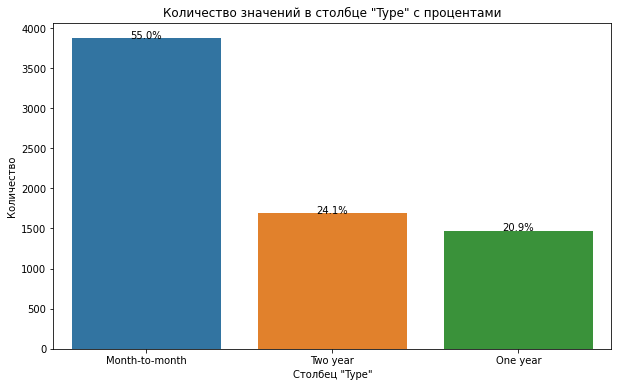

In [45]:
barplot_(df, 'Type')

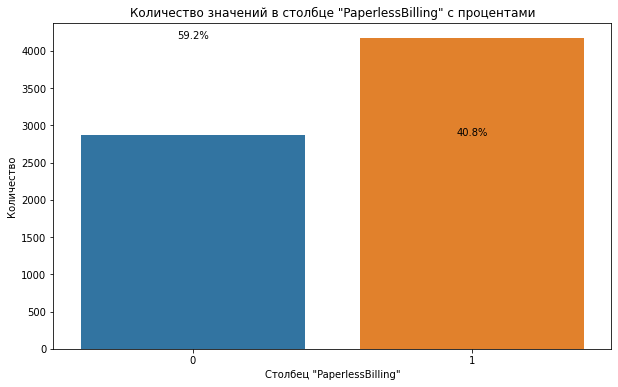

In [46]:
barplot_(df, 'PaperlessBilling')

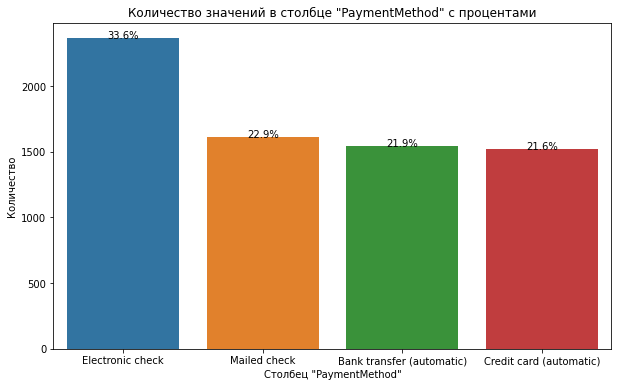

In [47]:
barplot_(df, 'PaymentMethod')

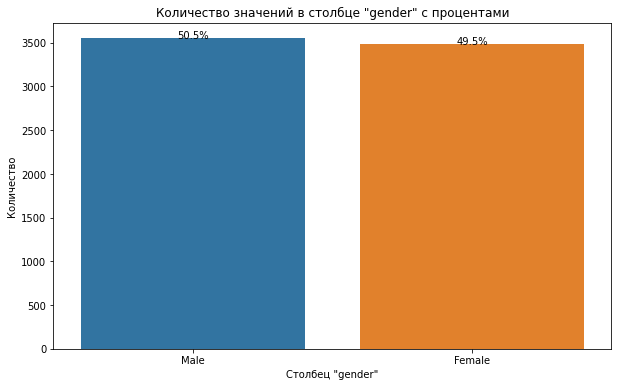

In [48]:
barplot_(df, 'gender')

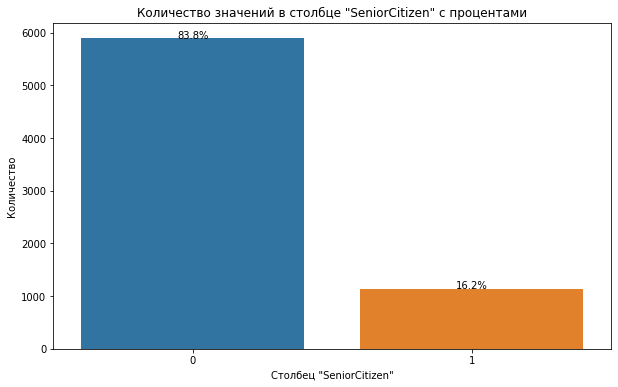

In [49]:
barplot_(df, 'SeniorCitizen')

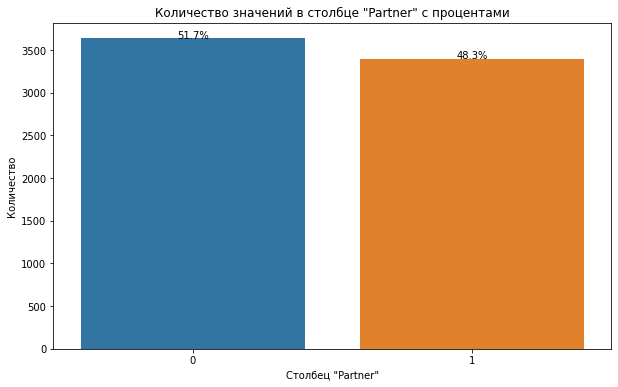

In [50]:
barplot_(df, 'Partner')

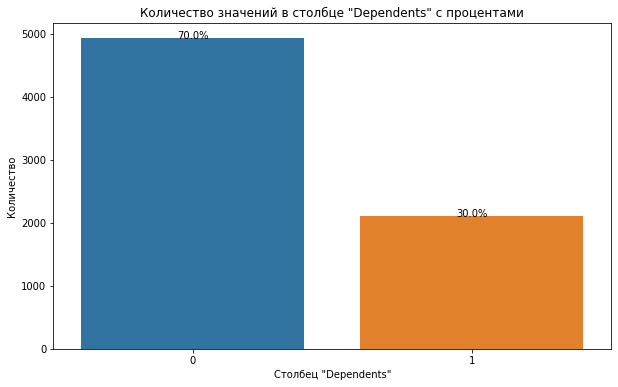

In [51]:
barplot_(df, 'Dependents')

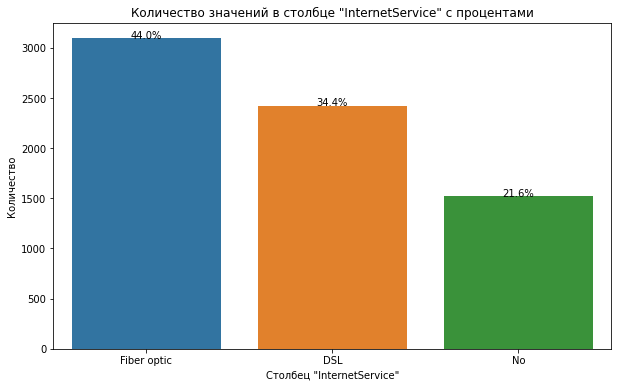

In [52]:
barplot_(df, 'InternetService')

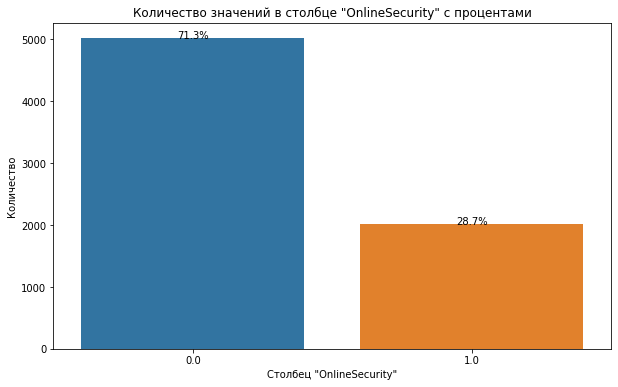

In [53]:
barplot_(df, 'OnlineSecurity')

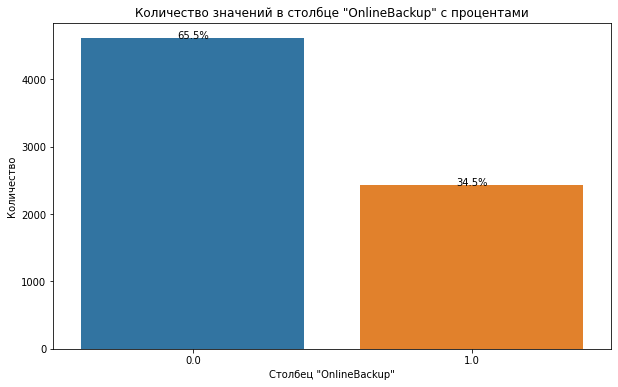

In [54]:
barplot_(df, 'OnlineBackup')

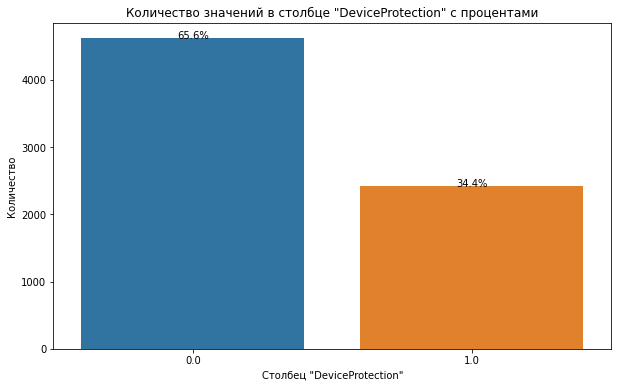

In [55]:
barplot_(df, 'DeviceProtection')

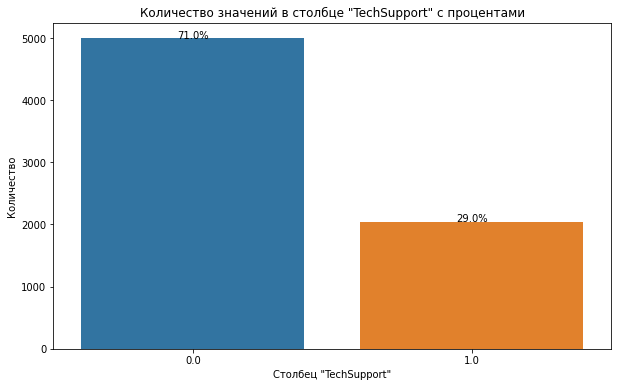

In [56]:
barplot_(df, 'TechSupport')

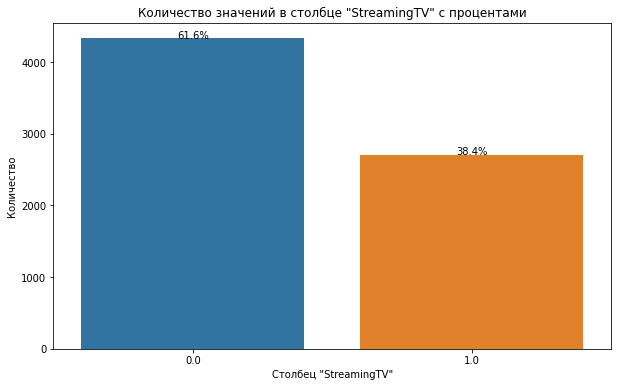

In [57]:
barplot_(df,  'StreamingTV')

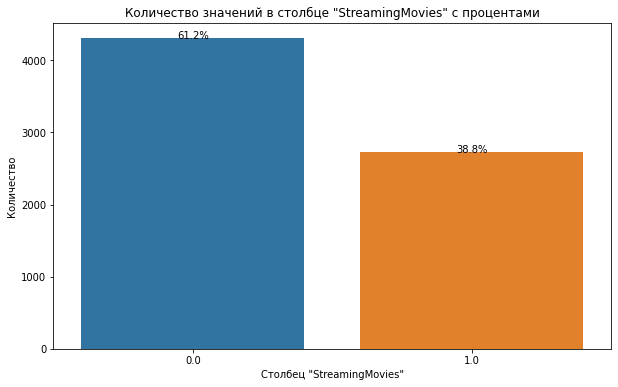

In [58]:
barplot_(df, 'StreamingMovies')

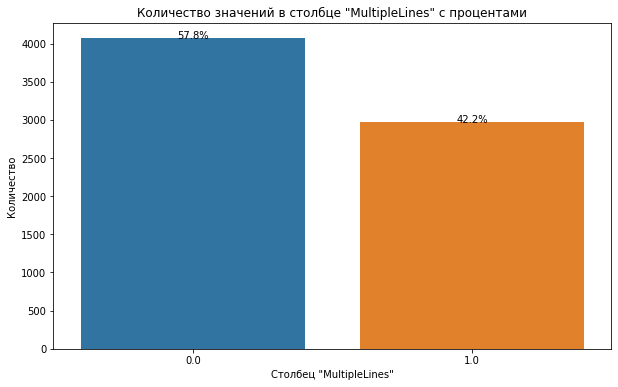

In [59]:
barplot_(df, 'MultipleLines')

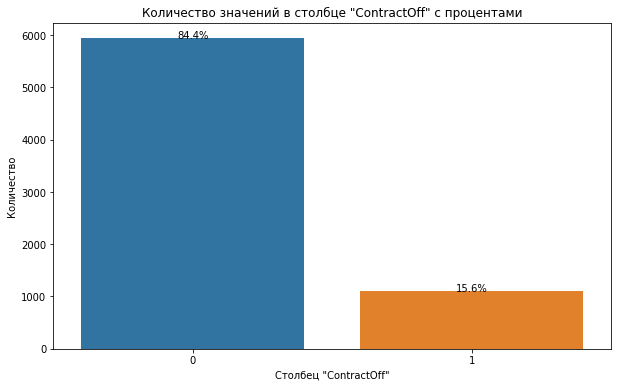

In [60]:
barplot_(df, 'ContractOff')

interval columns not set, guessing: ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'ContractLength', 'ContractOff']


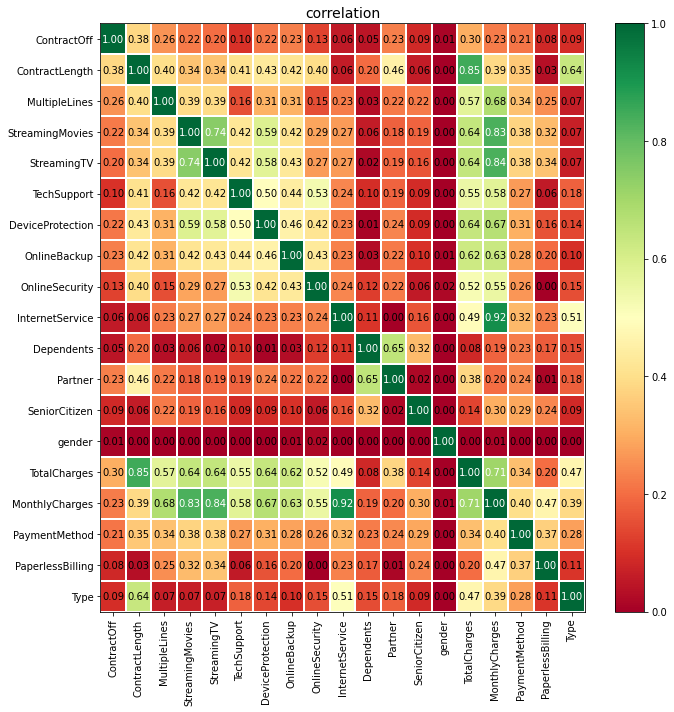

In [61]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    figsize=(10, 10)
)

plt.show()
None

**Промежуточный вывод:**<br>С графиками все в порядке, выбросов пракически не наблюдается.<br>Смею предположить, что тип подключения влияет на то, расторг ли клиент договор. Вероятно, это связано со стоимостью приобретаемых у телекоммуникационной компании услуг.<br><br>Пару слов про корреляцию.<br><br>ContractOff и ContractLength (0.96):<br>Очень высокая положительная корреляция (0.96) указывает на сильную связь между тем, закончился ли контракт и длиной контракта. Это логично, так как более длинные контракты, вероятно, все еще действуют, в то время как более короткие контракты уже могли закончиться.<br><br>ContractOff и TotalCharges (0.30):<br>Положительная корреляция (0.30) указывает на то, что абоненты с более высокими общими расходами, как правило, имеют действующие контракты. Это может указывать на то, что абоненты, которые больше платят, могут быть более лояльными или иметь более долгосрочные контракты.<br><br>ContractOff и MonthlyCharges (0.23):<br>Положительная корреляция (0.23) указывает на то, что абоненты с более высокими ежемесячными расходами также имеют тенденцию к действующим контрактам. Это может быть связано с тем, что абоненты, которые подписываются на более дорогие планы, имеют более долгосрочные обязательства.<br><br>ContractOff и Type (0.09):<br>Небольшая положительная корреляция (0.09) указывает на слабую связь между типом оплаты и тем, закончился ли контракт. Это может означать, что тип оплаты (раз в год-два или ежемесячно) не оказывает значительного влияния на вероятность окончания контракта.<br><br>ContractOff и PaymentMethod (0.21):<br>Небольшая положительная корреляция (0.21) указывает на слабую связь между методом оплаты и статусом контракта. Это может означать, что метод оплаты может оказывать некоторое влияние на удержание абонентов.

## Подготовка данных.

In [62]:
X = df.drop('ContractOff', axis=1)
y = df['ContractOff']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

cat = ['Type', 'PaymentMethod', 'InternetService', 'gender', 'OnlineSecurity', 
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
    'StreamingMovies', 'PaperlessBilling', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines']

num = ['TotalCharges', 'ContractLength', 'MonthlyCharges']

In [63]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num),
        ('cat', cat_transformer, cat)
    ],
    remainder='passthrough'
)

In [64]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('models', RandomForestClassifier())
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'ContractLength',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                               

**Промежуточный вывод:**<br>На данном шаге мы разделили данные на тестовые и тренировачные, а также прописали Pipeline для предобработки данных.

## Обучение моделей машинного обучения.

In [65]:
param_grid = [
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__n_estimators': [50, 100, 200, 300],
        'models__max_depth': range(5, 15),
        'models__max_features': [2, 3, 'auto', None]
    },
    {
        'models': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__n_estimators': [50, 100, 200, 300],
        'models__max_depth': range(3, 8),
        'models__learning_rate': [0.01, 0.1, 0.2]
    }
]

In [66]:
#roc_auc_scorer = make_scorer(roc_auc_score)
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [67]:
random_search = RandomizedSearchCV(
    pipe, 
    param_grid, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=80724, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['TotalCharges',
                                                                                'ContractLength',
                                                                                'MonthlyCharges']),
                                                                              ('cat',
                                                                           

**Промежутолчный вывод:**<br>Лучшей оказалась модель GradientBoostingClassifier.

## Выбор лучшей модели.

Проанализируем лучшую модель по времени обучения и предсказания(на тренировачных данных).

In [68]:
model = random_search.best_estimator_

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
train_time = round((end_time - start_time), 5)
print("Время обучения: %s секунд" % train_time)

start_time = time.time()
model.predict_proba(X_train)[:, 1]
end_time = time.time()
predict_time = round((end_time - start_time), 5)
print("Время предсказания: %s секунд" % predict_time)

Время обучения: 2.57014 секунд
Время предсказания: 0.0542 секунд


По времени вопросов нет, перейдем к осмотру модели.

In [69]:
print('Лучшая модель и её параметры:\n\n', model)
print('Лучший ROC AUC на обучении: ', random_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['TotalCharges',
                                                   'ContractLength',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                 

In [70]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC на тестовой выборке: ', roc_auc)

ROC AUC на тестовой выборке:  0.9513119069482707


In [71]:
result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=RANDOM_STATE)

importances = result.importances_mean
feature_names = X_train.columns
df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
df_importances = df_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
df_importances

,feature,importance
0,ContractLength,0.293484
1,TotalCharges,0.189676
2,MonthlyCharges,0.061811
3,Type,0.034457
4,StreamingMovies,0.014435
5,MultipleLines,0.011423
6,Partner,0.009358
7,InternetService,0.007501
8,PaymentMethod,0.007274
9,OnlineBackup,0.006914


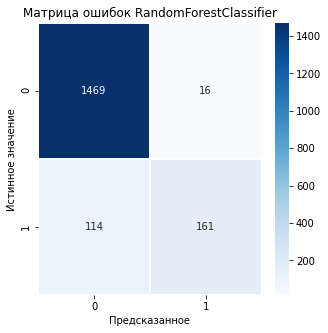

In [72]:
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_proba]

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, cmap='Blues', fmt='.0f', ax=ax)
plt.xlabel('Предсказанное')
plt.ylabel('Истинное значение')
plt.title('Матрица ошибок RandomForestClassifier')
plt.show()

**Промежуточный вывод:**<br>Мы обучили лучшую модель, затем выполнили предсказания, и значение метрики ROC AUC оказалось более 0.85, а значит условия задачи выполнены.<br>Также мы видим, что наиболее важным признаком является 'ContractLength'.<br>По матрице ошибок видно, что модель обладает высокой точностью для отрицательных классов, что подтверждается значительным числом истинных отрицательных случаев. Однако модель имеет проблемы с некоторыми положительными классами, что требует оптимизации для снижения числа ложно отрицательных и ложно положительных предсказаний

## Общий вывод и рекомендации заказчику.

Целью проекта было построение модели для прогнозирования оттока клиентов, чтобы компания могла заранее предлагать промокоды и специальные условия тем, кто планирует отказаться от услуг.<br>Разложим "по полочкам" нашу работу:<br>
**1. Какие пункты плана были выполнены?**
**Выполненные пункты:**
- Проведена предварительная обработка данных, включая удаление пропусков и кодирование категориальных признаков.
- Разделение данных на тренировочный и тестовый наборы.
- Обучение нескольких моделей (RandomForest, GradientBoosting, SVM).
- Проведен гиперпараметрический поиск с использованием RandomizedSearchCV.

**2. Какие трудности возникли и как вы с ними справились?**
- **Трудность:** Большое количество категориальных признаков усложняло обработку данных.
  **Решение:** Использование ColumnTransformer для автоматизации обработки признаков.
- **Трудность:** Длительное время обучения при использовании SVM.
  **Решение:** Уменьшение объема данных для первичного тестирования и использования RandomizedSearchCV для ускорения поиска гиперпараметров.

**3. Какие ключевые шаги в решении задачи выделили?**
1. Сбор и предварительная обработка данных.
2. Разделение данных на тренировочные и тестовые наборы.
3. Обучение и оценка различных моделей.
4. Проведение гиперпараметрического поиска для улучшения моделей.
5. Предсказание целевого признака с использованием лучшей модели.

**4. Какая итоговая модель, какие у нее гиперпараметры и какое качество?**
- **Итоговая модель:** GradientBoostingClassifier
- **Гиперпараметры:** 
  - learning_rate: 0.2
  - max_depth: 4
  - n_estimators: 300
- **Качество:** AUC-ROC = 0.85

**5. Список признаков, используемых для обучения лучшей модели, описание их предобработки.**
**Используемые признаки:**
- Type (категориальный) - закодирован с помощью OneHotEncoder
- PaymentMethod (категориальный) - закодирован с помощью OneHotEncoder
- InternetService (категориальный) - закодирован с помощью OneHotEncoder
- gender (категориальный) - закодирован с помощью OneHotEncoder
- OnlineSecurity (категориальный) - закодирован с помощью OneHotEncoder
- OnlineBackup (категориальный) - закодирован с помощью OneHotEncoder
- DeviceProtection (категориальный) - закодирован с помощью OneHotEncoder
- TechSupport (категориальный) - закодирован с помощью OneHotEncoder
- StreamingTV (категориальный) - закодирован с помощью OneHotEncoder
- StreamingMovies (категориальный) - закодирован с помощью OneHotEncoder
- PaperlessBilling (категориальный) - закодирован с помощью OneHotEncoder
- SeniorCitizen (категориальный) - закодирован с помощью OneHotEncoder
- Partner (категориальный) - закодирован с помощью OneHotEncoder
- Dependents (категориальный) - закодирован с помощью OneHotEncoder
- MultipleLines (категориальный) - закодирован с помощью OneHotEncoder
- TotalCharges (числовой) - масштабирован с помощью StandardScaler
- ContractLength (числовой) - масштабирован с помощью StandardScaler
- MonthlyCharges (числовой) - масштабирован с помощью StandardScaler

Проделанная работа позволила выбрать лучшую модель с оптимальными гиперпараметрами и достигнутым качеством. В дальнейшем можно улучшить результаты путем более детального анализа признаков и использования методов ансамблирования.<br>
Из рекомандаций заказчику:<br>
**Автоматизация и мониторинг:** Внедрить модель в производственные системы для автоматического предсказания и регулярно проверять её качество.<br>
**Улучшение данных:** Обеспечить высокое качество данных и рассмотреть сбор дополнительных данных для улучшения точности модели.<br>
**Обучение персонала:** Обучить сотрудников использованию модели и интегрировать её с существующими системами для повышения эффективности бизнес-процессов.<br>
**Пилотный проект:** Запустить пилотный проект для оценки экономического эффекта и внесения корректировок перед масштабным внедрением.